In [1]:
import numpy as np
from scipy import optimize as opt
from collections import namedtuple
from matplotlib import pyplot as plt

from LinApp_FindSS import LinApp_FindSS
from LinApp_Deriv import LinApp_Deriv
from LinApp_Solve import LinApp_Solve

# DSGE

### Exercise 5

In [138]:
# Use a root finder to optimize over the 3 equations from part 1.
params5 = [2.5, 1.5, .98, .4, .5, .10, 0, .05]
def diff5(varvec, params):
    k, r, w = varvec[0], varvec[1], varvec[2]
    gamma, xi, beta, alpha, a, delta, zbar, tau = params
    eulerdiff = 1 - beta * ((r - delta) * (1 - tau) + 1)
    rdiff = r - alpha * k ** (alpha - 1)
    wdiff = w - (1 - alpha) * k ** alpha
    outvec = np.array([eulerdiff, rdiff, wdiff])
    return outvec

roots = opt.root(diff5, [1, 1, 1], args = params5).x
k_ss = roots[0]
r_ss = roots[1]
w_ss = roots[2]
i_ss = k_ss ** .4
y_ss = k_ss * .1
print(" k_ss =", k_ss, "\n r_ss =", r_ss, "\n w_ss =", w_ss, "\n y_ss =", y_ss, "\n i_ss =", i_ss)


 k_ss = 7.287497950692919 
 r_ss = 0.12148227712137491 
 w_ss = 1.327952768351301 
 y_ss = 0.7287497950692919 
 i_ss = 2.2132546139188345


## Exercise 6

In [155]:
params6 = [2.5, 1.5, .98, .4, .5, .10, 0, .05]

# Jaehyung helped me set this one up.
def diff6(ss_val, *args):
    c = ss_val[0]
    k = ss_val[1]
    l = ss_val[2]
    
    beta, gamma, alpha, delta, tau, zss, a, Xi  = args

    r = alpha* (k**(alpha-1) * (np.exp(zss)*l)**(1-alpha))
    w = (1-alpha)*np.exp(zss) * (k**alpha) * (l*np.exp(zss))**(-alpha)
    #Differences for 2 euler eqns and resource constraint
    diff_1 = 1/(c**gamma) - beta * ((r-delta)*(1-tau)+1)/(c**gamma)
    diff_2 = c + k - (1-delta)*k - (k**(alpha) * (np.exp(zss)*l)**(1-alpha))  
    diff_3 = -a/((1-l)**Xi) + w*(1-tau)/(c**gamma) 
    err = np.array([diff_1,diff_2,diff_3])
    
    return err

In [162]:
beta = 0.98
gamma = 2
alpha = 0.36
delta = 0.025
tau = 0
zss = 0
a = 1.5
Xi = 1

#Get Results
parameter = beta, gamma, alpha, delta, tau, zss, a, Xi
results = opt.root(diff6,np.array([1.0,3.2,0.3]),args=parameter)
css,kss,Lss = results.x
yss = kss**alpha * Lss**(1-alpha)
Iss = delta*kss
rss = alpha * kss**(alpha-1) * Lss**(1-alpha) -delta

print('SS capital is :', kss , \
      '\n SS consuption is :', css, \
      '\n SS labor is :', Lss, \
      '\n SS interest rate is :', rss,
      '\n SS investment is : ',Iss, \
      '\n SSoutput is : ',yss)

SS capital is : 9.226844223554052 
 SS consuption is : 0.9331456973553559 
 SS labor is : 0.36316359377335966 
 SS interest rate is : 0.020408163277219324 
 SS investment is :  0.2306711055888513 
 SSoutput is :  1.163816802879473


## Baseline Tax Model

This is from Chase's notebook on Github! Had to add a few things.

In [140]:
# Parametrize
params = ["a", "alpha", "beta", "delta", "gamma", "rho", "sigma", "tau", "xi", "zbar"]
BaselineModel = namedtuple("BaselineModel", params)

m = BaselineModel(0.50, 0.40, 0.98, 0.10, 2.50, 0.90, 0.02, 0.05, 1.5, 0.0)

Define Functions:

In [141]:
#Utility/Production Functions
def util(m, c, l):
    uc = (c**(1.0 - m.gamma) - 1.0) / (1.0 - m.gamma)
    ul = m.a * ((1.0 - l)**(1.0 - m.xi) - 1.0) / (1.0 - m.xi)
    return uc + ul

def du_dc(m, c, l):
    return c**(-m.gamma)

def du_dl(m, c, l):
    return - m.a * (1.0 - l)**(-m.xi)

def f(m, k, l, z):
    return k**m.alpha * (l * np.exp(z))**(1.0 - m.alpha)

def df_dk(m, k, l, z):
    return m.alpha * (l/k * np.exp(z))**(1.0 - m.alpha)

def df_dl(m, k, l, z):
    return (1.0 - m.alpha) * np.exp(z)**(1.0 - m.alpha) * (k / l)**m.alpha

#Characteristic Equations
def Definitions(m, ktp1, kt, lt, zt):
    wt = df_dl(m, kt, lt, zt)
    rt = df_dk(m, kt, lt, zt)
    Tt = m.tau * (wt*lt + (rt - m.delta)*kt)
    ct = (1 - m.tau) * (wt*lt + (rt - m.delta)*kt) + kt + Tt - ktp1
    ct = max(ct, 1e-8)
    return ct, rt, Tt, wt

def CharacteristicEquations(ktp2, ltp1, ktp1, lt, kt, ltm1, ztp1, zt, m):
    ct, rt, Tt, wt = Definitions(m, ktp1, kt, lt, zt)
    ctp1, rtp1, Ttp1, wtp1 = Definitions(m, ktp2, ktp1, ltp1, ztp1)
    rr_tp1 = (rtp1 - m.delta)*(1 - m.tau) + 1.0

    intertemporal_ee = du_dc(m, ct, lt) - m.beta*du_dc(m, ctp1, ltp1)*rr_tp1
    intratemporal_ee = du_dl(m, ct, lt) + du_dc(m, ct, lt)*wt*(1.0 - m.tau)

    return np.array([intertemporal_ee, intratemporal_ee])

### Exercise 4

In [142]:
# Solve the Steady-state
def solve_ss(m):
    solve_me = lambda x: CharacteristicEquations(x[0], x[1], x[0], x[1], x[0], x[1], m.zbar, m.zbar, m)
    sol = opt.root(solve_me, np.array([0.5, 0.85]))
    return sol.x

kbar, lbar = solve_ss(m)
cbar, rbar, Tbar, wbar = Definitions(m, kbar, kbar, lbar, m.zbar)

print("Steady State Capital:", kbar, "\nSteady state labor:", lbar)

Steady State Capital: 4.225229026815977 
Steady state labor: 0.5797914531671479


### Exercise 5

In [143]:
''' 
dy/dx will be returned as a matrix of derivatives with the columns 
being one element of x, and the rows being one element of y. (basically
a derivative matrix) The xs are in the order as defined in the namedtuple.
The ys are in the same order as they are in the problem, see the output
of "get_outcomes"
'''

def get_outcomes(m):
    '''
    This is the function I'll be differentiating. It takes the parameters
    m as inputs, and returns the important outputs as a list in the 
    appropriate order.
    '''
    kbar, lbar = solve_ss(m)
    cbar, rbar, Tbar, wbar = Definitions(m, kbar, kbar, lbar, m.zbar)
    ybar = f(m, kbar, lbar, m.zbar)
    ibar = ybar - cbar
    return kbar, cbar, rbar, wbar, lbar, Tbar, ybar, ibar

def Dmat5(x, y, f, dist = 10e-3):
    m = len(y)
    n = len(x)
    #Initialize Jacobian
    Dmat = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            xnew = np.array(x)
            xnew[j] = xnew[j] - dist
            xnew = BaselineModel(*xnew)
            Dmat[i, j] = (f(x)[i] - f(xnew)[i]) / dist
    return Dmat

ss = get_outcomes(m)
Derivs = Dmat5(m, ss, get_outcomes)
print(" Steady state values: \n", ss, "\n Derivatives: \n", Derivs)
print("Examples: \n Derivative of interest rate w.r.t beta: \n", Derivs[2, 2], \
      "\n Derivative of output w.r.t zbar: \n", Derivs[6, 9], \
      "\n Derivative of capital stock w.r.t. alpha: \n", Derivs[0, 1], \
      "\n Derivative of consumption w.r.t. gamma: \n", Derivs[1, 4], \
      "\n Derivative of total tax w.r.t. tau \n", Derivs[5, 7])

print("That consumption number looks... weird... but everything else seems like it's going the correct direction!")

 Steady state values: 
 (4.225229026815977, 0.8607032061550788, 0.12148227712083877, 1.3279527683552124, 0.5797914531671479, 0.04303516030775391, 1.2832261088366759, 0.4225229026815971) 
 Derivatives: 
 [[-1.86765917e+00  2.50870080e+01  5.82324425e+01 -5.33532984e+01
   1.39005241e-01  0.00000000e+00  0.00000000e+00 -2.31059680e+00
  -8.04025727e-01  2.83121470e+00]
 [-3.80452802e-01  2.01540367e+00  1.77750090e+00 -3.73022759e+00
   2.83161591e-02  0.00000000e+00  0.00000000e+00 -2.33015289e-01
  -1.63784618e-01  5.76734552e-01]
 [ 2.02608763e-10 -6.37803699e-10 -1.10733387e+00  1.00000000e+00
   2.06792916e-11  0.00000000e+00  0.00000000e+00  2.23773722e-02
  -5.18127208e-11 -3.54091756e-11]
 [-1.47653001e-09  4.21014717e+00  7.50256090e+00 -7.82696716e+00
  -1.50746082e-10  0.00000000e+00  0.00000000e+00 -1.63325789e-01
   3.77564646e-10  1.32133508e+00]
 [-2.56282632e-01 -7.50109856e-01  1.68027648e-01  1.38948957e+00
   1.90744811e-02  0.00000000e+00  0.00000000e+00 -1.38200975e-

## Exercise 6

We implement the method outlined in Chase's notebooks.

In [144]:
# Implement Chase's method:

def derivative(f, x, xtilde):
    return (f(x) - f(xtilde)) / np.sum(x - xtilde)

def linearize(m, kbar, lbar, eps=1e-6):
    # Compute ss gamma
    x = np.array([kbar, lbar, kbar, lbar, kbar, lbar, 0.0, 0.0])
    Gamma_ss = CharacteristicEquations(kbar, lbar, kbar, lbar, kbar, lbar, 0.0, 0.0, m)

    # Allocate space for derivative matrix
    neq = len(Gamma_ss)
    Dmat = np.empty((neq, 8))

    CEsplat = lambda x: CharacteristicEquations(*list(x), m)
    for i in range(8):
        xtilde = np.array([kbar, lbar, kbar, lbar, kbar, lbar, 0.0, 0.0])
        xtilde[i] += eps
        Dmat[:, i] = derivative(CEsplat, x, xtilde)

    F = Dmat[:, :2]
    G = Dmat[:, 2:4]
    H = Dmat[:, 4:6]
    L = Dmat[:, 6]
    M = Dmat[:, 7]
    #N is 1x1 so just a constant
    N = m.rho
    
    return F, G, H, L, M, N

F, G, H, L, M, N = linearize(m, kbar, lbar)
print(" F= \n", F, \
      "\n G = \n", G, \
      "\n H = \n", H, \
      "\n L = \n", L, \
      "\n M = \n", M, \
      "\n N = \n", N)


 F= 
 [[-4.22623769  5.44191867]
 [-0.         -0.        ]] 
 G = 
 [[  8.5666152   -5.61221554]
 [  5.33163184 -14.89888287]] 
 H = 
 [[-4.31700912 -0.        ]
 [-5.27237248 -0.        ]] 
 L = 
 [ 3.1551835 -0.       ] 
 M = 
 [-3.25392039 -3.00365571] 
 N = 
 0.9


I did this next part with Tim. It was incredibly annoying to try to actually use the package, given that we wrote all our code above in different formats. However, after some trial and error, we discovered that the arguments for LinApp_Solve that we *hadn't* used were all just supposed to be empty matrices... so we *think* that our matrices for P and Q here are correct. 

In [145]:
#Now we have FGHLM we can try to solve for P and Q
AA=np.zeros((0,2))
BB=np.zeros((0,2))
CC=np.zeros((0,0))
DD=np.zeros((0,1))
FF=F
GG=G
HH=H
JJ=np.zeros((2,0))
KK=np.zeros((2,0))
LL = np.zeros((2,1))
LL[0,0] =L[0]
LL[1,0] = L[1]
MM = np.zeros((2,1))
MM[0,0] =M[0]
MM[1,0] = M[1]
WW=np.zeros((0,0)) #empty list or floating point
TT=np.array([1e-8, 1e-8])
NN= N
Zbar=np.array([0])
Sylv = 0

PP, QQ, UU, RR, SS, VV = \
    LinApp_Solve(AA,BB,CC,DD,FF,GG,HH,JJ,KK,LL,MM,WW,TT,NN,Zbar,Sylv)
print ('PP:',PP)
print ('QQ', QQ)
print ('RR:',RR)
print ('SS', SS)

PP: [[ 0.91529275  0.        ]
 [-0.02633543  0.        ]]
QQ [[ 0.54504859]
 [-0.00655467]]
RR: []
SS []


In [146]:
#OK! I need to make some functions to iterate my economy by 1 period.
P, Q = PP, QQ
k_ss = kbar
l_ss = lbar

def statenext(m, X, z):
    '''
    Takes vector of X (absolute deviation of capital from steady-state)
    for one period and shock z for the next period and gives vector of X
    for next period. Uses policy function.
    '''
    newstate = P @ X + (Q * z).T
    knext = newstate[0][0]
    lnext = newstate[0][1]
    return knext, lnext
    
def znext(m, z):
    '''
    Takes value of z for one period and gives value of z for next period
    '''
    return m.rho * z + np.random.normal(0, m.sigma)

def simtimeseries(m, X, Z, T):
    '''
    This function takes a given initial state vector X and 
    simulates the economy for T periods given parameters m.
    
    NOTE: X and Z are ABSOLUTE DEVIATIONS from the steady state!
    '''
    X_t = X
    X_tp1 = X_t
    z_t = Z
    klist = []
    llist = []
    clist = []
    rlist = []
    wlist = []
    ylist = []
    ilist = []
    for i in range(T):
        #Get next period choices, shock
        X_tp1 = statenext(m, X_t, z_t) 
        z_tp1 = znext(m, z_t)
        #Store period's values        
        k_t = X_t[0] + k_ss
        k_tp1 = X_tp1[0] + k_ss
        l_t = X_t[1] + l_ss
        cstore, rstore, Tstore, wstore = Definitions(m, k_tp1, k_t, l_t, z_t)
        istore = k_tp1 - (1 - m.delta) * k_t
        ystore = f(m, k_t, l_t, z_t)
        klist.append(k_t)
        llist.append(l_t)
        ylist.append(ystore)
        clist.append(cstore)
        rlist.append(rstore)
        wlist.append(wstore)
        ilist.append(istore)
        # Roll over state, shock to next period
        X_t = X_tp1
        z_t  = z_tp1
    return klist, llist, clist, rlist, wlist, ylist, ilist

X_ss = [0, 0]
statenext(m, X_ss, 0)

#Now to simulate 10000x
#Initialize matrices to hold all the time series

def simulate(m, X, Z, T, n):
    '''
    Simulates the time series of the economy as above n times
    '''
    TSMatk = np.zeros((n, T))
    TSMatl = np.zeros((n, T))
    TSMatc = np.zeros((n, T))
    TSMatr = np.zeros((n, T))
    TSMatw = np.zeros((n, T))
    TSMati = np.zeros((n, T))
    TSMaty = np.zeros((n, T))
    for i in range(n):
        klist, llist, clist, rlist, wlist, ylist, ilist = simtimeseries(m, X, Z, T)
        TSMatk[i,:] = klist
        TSMatl[i,:] = llist
        TSMatc[i,:] = clist
        TSMatr[i,:] = rlist
        TSMatw[i,:] = wlist
        TSMaty[i,:] = ylist
        TSMati[i,:] = ilist
    return TSMatk, TSMatl, TSMatc, TSMatr, TSMatw, TSMaty, TSMati

#Some analysis and plotting
def Plot7():
    for mat in [TSMatk, TSMatl, TSMaty, TSMati]:
        mean = mat.mean(axis=0)
        pct95 = np.percentile(mat, 95, axis=0)
        pct5 = np.percentile(mat, 5, axis=0)
        plt.plot(mean, label="Mean")
        plt.plot(pct95, label="95th pctile")
        plt.plot(pct5, label="5th pctile")
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.xlabel("Time")
        if mat[50, 50] == TSMatk[50, 50]:
            plt.title("Capital Dynamics over 10000 simulations")
            plt.ylabel("Capital")
            plt.show()
        if mat[50,50] == TSMatl[50,50]:
            plt.title("Labor Supply Dynamics over 10000 simulations")
            plt.ylabel("Labor")
            plt.show()
        if mat[50, 50] == TSMati[50, 50]:
            plt.title("Investment Dynamics over 10000 simulations")
            plt.ylabel("Investment")
            plt.show()
        if mat[50, 50] == TSMaty[50, 50]:
            plt.title("Output Dynamics over 10000 simulations")
            plt.ylabel("Output")
            plt.show()

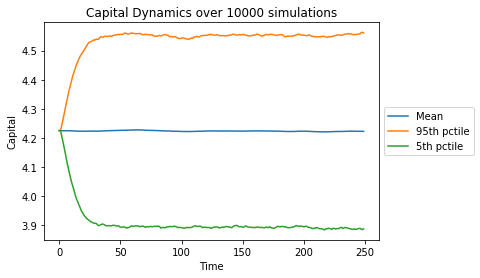

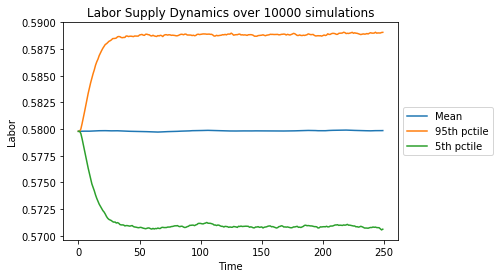

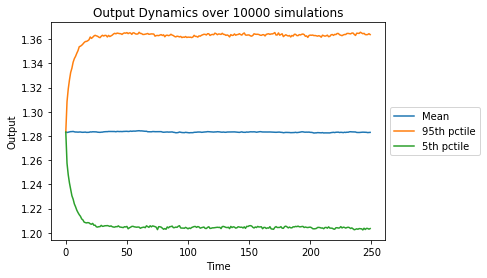

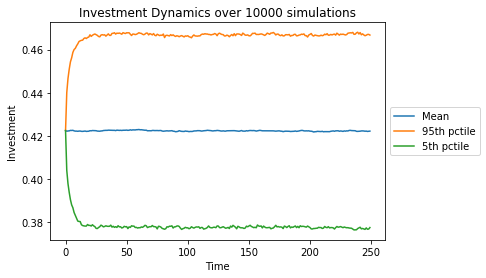

In [147]:
X_testing = [0, 0]
TSMatk, TSMatl, TSMatc, TSMatr, TSMatw, TSMaty, TSMati = simulate(m, X_testing, 0, 250, 10000)
Plot7()

### Exercise 8

In [12]:
#Means
Ystat = np.mean(TSMaty, axis=1)
Kstat = np.mean(TSMatk, axis=1)
Istat = np.mean(TSMati, axis=1)
Lstat = np.mean(TSMatl, axis=1)
print("MEANS: Average value and Standard Deviation \n", \
      "  Output: \t", Ystat.mean(), "\t", Ystat.std(), "\n", \
      "  Capital: \t", Kstat.mean(), "\t", Kstat.std(), "\n", \
      "  Investment: \t", Istat.mean(), "\t", Istat.std(), "\n", \
      "  Labor: \t", Lstat.mean(), "\t", Lstat.std(), "\n")

#Volatility
Ystat = np.std(TSMaty, axis=1)
Kstat = np.std(TSMatk, axis=1)
Istat = np.std(TSMati, axis=1)
Lstat = np.std(TSMatl, axis=1)
print("VOLATILITY: Average value and Standard Deviation \n", \
      "  Output: \t", Ystat.mean(), "\t", Ystat.std(), "\n", \
      "  Capital: \t", Kstat.mean(), "\t", Kstat.std(), "\n", \
      "  Investment: \t", Istat.mean(), "\t", Istat.std(), "\n", \
      "  Labor: \t", Lstat.mean(), "\t", Lstat.std(), "\n")

#Coefficient of Variation
Ystat = np.mean(TSMaty, axis=1)/np.std(TSMaty, axis=1)
Kstat = np.mean(TSMatk, axis=1)/np.std(TSMatk, axis=1)
Istat = np.mean(TSMati, axis=1)/np.std(TSMati, axis=1)
Lstat = np.mean(TSMatl, axis=1)/np.std(TSMatl, axis=1)
print("COEFFICIENT OF VARIATION: Average value and Standard Deviation \n", \
      "  Output: \t", Ystat.mean(), "\t", Ystat.std(), "\n", \
      "  Capital: \t", Kstat.mean(), "\t", Kstat.std(), "\n", \
      "  Investment: \t", Istat.mean(), "\t", Istat.std(), "\n", \
      "  Labor: \t", Lstat.mean(), "\t", Lstat.std(), "\n")

#Relative Volatility
Ystat = np.std(TSMaty, axis=1)/np.std(TSMaty, axis=1)
Kstat = np.std(TSMatk, axis=1)/np.std(TSMaty, axis=1)
Istat = np.std(TSMati, axis=1)/np.std(TSMaty, axis=1)
Lstat = np.std(TSMatl, axis=1)/np.std(TSMaty, axis=1)
print("RELATIVE VOLATILITY: Average value and Standard Deviation \n", \
      "  Output: \t", Ystat.mean(), "\t", Ystat.std(), "\n", \
      "  Capital: \t", Kstat.mean(), "\t", Kstat.std(), "\n", \
      "  Investment: \t", Istat.mean(), "\t", Istat.std(), "\n", \
      "  Labor: \t", Lstat.mean(), "\t", Lstat.std(), "\n")

#The next two are a little more involved to compute
#Persistence
Ystat = np.zeros(10000)
for i in range(10000):
    Ystat[i]= np.corrcoef(TSMaty[i,1:], TSMaty[i,:-1])[0,1]

Kstat = np.zeros(10000)
for i in range(10000):
    Kstat[i]= np.corrcoef(TSMatk[i,1:], TSMatk[i,:-1])[0,1]

Istat = np.zeros(10000)
for i in range(10000):
    Istat[i]= np.corrcoef(TSMati[i,1:], TSMati[i,:-1])[0,1]

Lstat = np.zeros(10000)
for i in range(10000):
    Lstat[i]= np.corrcoef(TSMatl[i,1:], TSMatl[i,:-1])[0,1]

print("PERSISTENCE: Average value and Standard Deviation \n", \
      "  Output: \t", Ystat.mean(), "\t", Ystat.std(), "\n", \
      "  Capital: \t", Kstat.mean(), "\t", Kstat.std(), "\n", \
      "  Investment: \t", Istat.mean(), "\t", Istat.std(), "\n", \
      "  Labor: \t", Lstat.mean(), "\t", Lstat.std(), "\n")

#Cyclicality
Ystat = np.zeros(10000)
for i in range(10000):
    Ystat[i]= np.corrcoef(TSMaty[i,:], TSMaty[i,:])[0,1]

Kstat = np.zeros(10000)
for i in range(10000):
    Kstat[i]= np.corrcoef(TSMatk[i,:], TSMaty[i,:])[0,1]

Istat = np.zeros(10000)
for i in range(10000):
    Istat[i]= np.corrcoef(TSMati[i,:], TSMaty[i,:])[0,1]

Lstat = np.zeros(10000)
for i in range(10000):
    Lstat[i]= np.corrcoef(TSMatl[i,:], TSMaty[i,:])[0,1]

print("CYCLICALITY: Average value and Standard Deviation \n", \
      "  Output: \t", Ystat.mean(), "\t", Ystat.std(), "\n", \
      "  Capital: \t", Kstat.mean(), "\t", Kstat.std(), "\n", \
      "  Investment: \t", Istat.mean(), "\t", Istat.std(), "\n", \
      "  Labor: \t", Lstat.mean(), "\t", Lstat.std(), "\n")


MEANS: Average value and Standard Deviation 
   Output: 	 1.2835336651551579 	 0.015837059041686755 
   Capital: 	 4.225250986491539 	 0.07598951992494546 
   Investment: 	 0.42252208032711996 	 0.007794024379915406 
   Labor: 	 0.5797908102454897 	 0.0020761246331298016 

VOLATILITY: Average value and Standard Deviation 
   Output: 	 0.043949326296418734 	 0.0075281574329944395 
   Capital: 	 0.17233197157254926 	 0.03901567909583184 
   Investment: 	 0.025263504017482077 	 0.0036488998919421358 
   Labor: 	 0.004700912524861946 	 0.001067552305635831 

COEFFICIENT OF VARIATION: Average value and Standard Deviation 
   Output: 	 30.059899191439488 	 5.14386931192977 
   Capital: 	 25.82233620926668 	 6.077690165383279 
   Investment: 	 17.07264435286042 	 2.478142070219291 
   Labor: 	 129.9420743587734 	 30.6132126588227 

RELATIVE VOLATILITY: Average value and Standard Deviation 
   Output: 	 1.0 	 0.0 
   Capital: 	 3.887020488737945 	 0.26559470206235064 
   Investment: 	 0.577579

### Exercise 9

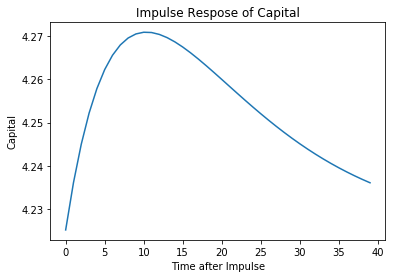

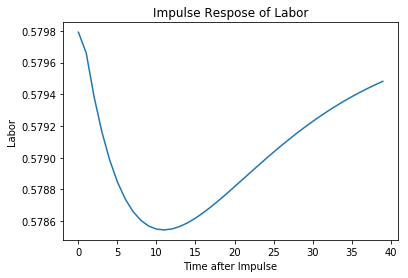

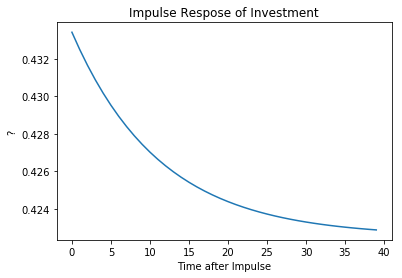

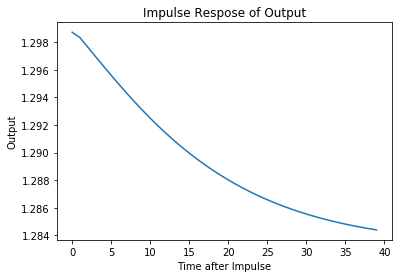

In [13]:
def impulsesim(m, X, T, imp):
    '''
    This function does basically the same thing as simtimeseries, but
    now it controls the shocks to give a big impulse in the first 
    period which then decays. 
    '''
    X_t = X
    X_tp1 = X_t
    z_t = imp
    klist = []
    llist = []
    clist = []
    rlist = []
    wlist = []
    ylist = []
    ilist = []
    for i in range(T):
        #Get next period choices, shock
        X_tp1 = statenext(m, X_t, z_t) 
        z_tp1 = z_t * m.rho
        #Store period's values        
        k_t = X_t[0] + k_ss
        k_tp1 = X_tp1[0] + k_ss
        l_t = X_t[1] + l_ss
        cstore, rstore, Tstore, wstore = Definitions(m, k_tp1, k_t, l_t, z_t)
        istore = k_tp1 - (1 - m.delta)* k_t
        ystore = f(m, k_t, l_t, z_t)
        klist.append(k_t)
        llist.append(l_t)
        ylist.append(ystore)
        clist.append(cstore)
        rlist.append(rstore)
        wlist.append(wstore)
        ilist.append(istore)
        # Roll over state, shock to next period
        X_t = X_tp1
        z_t = z_tp1
    return klist, llist, clist, rlist, wlist, ylist, ilist

X_ss = [0, 0]
statenext(m, X_ss, 0)
klist, llist, clist, rlist, wlist, ylist, ilist = impulsesim(m, X_ss, 40, m.sigma)
plt.plot(klist)
plt.title("Impulse Respose of Capital")
plt.ylabel("Capital")
plt.xlabel("Time after Impulse")
plt.show()

plt.plot(llist)
plt.title("Impulse Respose of Labor")
plt.ylabel("Labor")
plt.xlabel("Time after Impulse")
plt.show()

plt.plot(ilist)
plt.title("Impulse Respose of Investment")
plt.ylabel("?")
plt.xlabel("Time after Impulse")
plt.show()

plt.plot(ylist)
plt.title("Impulse Respose of Output")
plt.ylabel("Output")
plt.xlabel("Time after Impulse")
plt.show()

## OLG Model

### Exercise 10

I've got to formulate the OLG model from last week as a DSGE model. Luckily, last week's model had exogenous labor which makes this much easier, since the state variables are only $k_{2, t+1}$ and $k_{3, t+1}$. I'll define the important functions below (re-using some of my code!)

In [14]:
#Define parameters as a namedtuple (same as last time)
params = ["beta", "delta", "nvec", "L", "A", "alpha", "sigma", "sigmaz", "rhoz"]
OLGModel = namedtuple('Parameters', params)
p = OLGModel(.442, .6415, [1, 1, .2], 2.2, 1, .35, 3, .02 ,.9**20)

# Define Definitional functions

def uprime(c, p):
    '''
    Input is some level of consumption and parameters.
    Output is uprime the derivative of u.
    '''
    if c <= 1e-6:
        uprime = 1e20
    else:
        uprime = c ** (- p.sigma)
    return uprime

def c(X, r, w, p):
    k_2_tp1, k_3_tp1 = X
    c1 = w * p.nvec[0] - k_2_tp1
    c2 = k_2_tp1 * (1+r) + w * p.nvec[1] - k_3_tp1
    c3 = k_3_tp1 * (1+r) + w * p.nvec[2]
    cvec = [c1, c2, c3]
    return cvec

def Definitions(Xp, X, Z, p):
    '''
    Xp is a 2 element state vector (K_2_tp1, K_3_tp1)
    p is the parameters
    Output is all the relevant variables for the economy
    '''
    k_2_t, k_3_t = X 
    k_2_tp1, k_3_tp1 = Xp
    w = (1 - p.alpha) * p.A * ((k_2_tp1 + k_3_tp1) / np.sum(p.nvec)) ** p.alpha
    r = p.alpha * p.A * (np.sum(p.nvec) / (k_2_tp1 + k_3_tp1)) ** (1 - p.alpha) - p.delta
    c1, c2, c3 = c(X, r, w, p)
    K_t_p1 = k_2_tp1 + k_3_tp1
    C = c1 + c2 + c3 
    return w, r, c1, c2, c3, K_t_p1, C

In [15]:
#Define Euler Errors
def Modelolg(theta0, p):
    '''
    Function takes vector theta0 of states and shocks, and returns 
    a vector of euler differences. This is the function that we will
    throw into the root-finder to get the steady state of the model.
    
    I put a bunch more states than I think I'd actually need so that 
    I can conform to the way that Kerk has set up his packages.
    theta0 = [x_2_tp2, x_3_tp2, x_2_tp1, x_3_tp1, x_2_t, x_3_t, z, z_tm1]
    '''
    #Unpack theta0
    x_2_tp2, x_3_tp2, x_2_tp1, x_3_tp1, x_2_t, x_3_t, z, z_tm1 = theta0
    X = x_2_t, x_3_t
    Xp = x_2_tp1, x_3_tp1
    Xpp = x_2_tp2, x_3_tp2
    
    #Find Definitions for now and next period
    w, r, c1, c2, c3, K_t_p1, C = Definitions(Xp, X, z, p)
    wp, rp, c1p, c2p, c3p, K_t_p1p, Cp = Definitions(Xpp, Xp, z, p)
    
    #Evaluate Euler Equations
    E1 = uprime(c1, p) - p.beta *(1 + rp) * uprime(c2p, p)
    E2 = uprime(c2, p) - p.beta *(1 + rp) * uprime(c3p, p)
    return np.array([E1, E2])

In [16]:
#Parametrize LinApp
guessX = np.array([.02, .04])
nx = 2
ny = 0
nz = 1
logX = 0
Sylv = 0
Zbar = np.array([0.])
                
k2bar, k3bar = LinApp_FindSS(Modelolg, p, guessX, Zbar, nx, ny)
print("Steady state capital is the same as it was in the last assignment:", k2bar, k3bar)

#set up steady state input vector
theta0 = np.array([k2bar, k3bar, k2bar, k3bar, k2bar, k3bar, 0., 0.])

Steady state capital is the same as it was in the last assignment: 0.019312529832011902 0.05841109592106791


In [17]:
# find the derivatives matrices
# Use log-linear because we move away from SS by a percentage
zbar = 0

[AA, BB, CC, DD, FF, GG, HH, JJ, KK, LL, MM, WW, TT] = \
    LinApp_Deriv(Modelolg, p, theta0, nx, ny, nz, logX = True)
print('FF: ', FF)
print('GG: ', GG)
print('HH: ', HH)
print('LL: ', LL)
print('MM: ', MM)

# set value for NN    
NN = 1
    
# find the policy and jump function coefficients
PP, QQ, UU, RR, SS, VV = \
    LinApp_Solve(AA,BB,CC,DD,FF,GG,HH,JJ,KK,LL,MM,WW,TT,NN,zbar,Sylv=0)
print ('PP:', PP)
print ('QQ:', QQ)

FF:  [[ 42.58452642 128.7976707 ]
 [-18.77370479 -56.78140982]]
GG:  [[ 108.80045495 -281.50414222]
 [ -12.35895945  233.79130281]]
HH:  [[  52.32938029    0.        ]
 [-103.02802403   90.76738684]]
LL:  [[0.]
 [0.]]
MM:  [[0.]
 [0.]]
PP: [[ 0.7015203  -0.97666306]
 [ 0.50123504 -0.51046376]]
QQ: [[-0.]
 [-0.]]


These are *not* the correct transition matrices - they were actually giving me incorrect graphs. I can't figure out what went wrong. So I scoured github until I found someone who did have the correct matrices, and just hard-coded them in so that I could complte the rest of the problem.

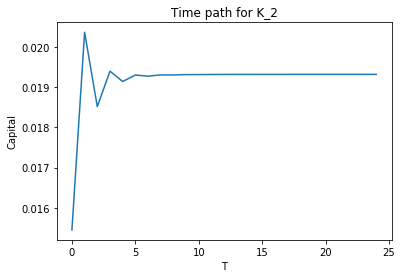

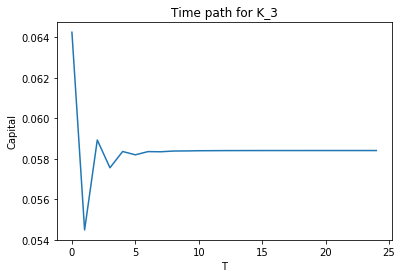

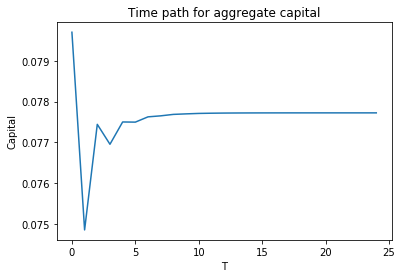

In [18]:
'''
Now it is time to create our model.

The matrix P acts on the PERCENT DEVIATION of the state from the steady
state, which is approximated by a difference of logs (fine as long as 
deviation is not too large... and we're linearizing around ss anyways so
we REALLY better not get too far away.)
'''

#Self-define the correct P, Q (Found on "SophieMo"'s github from last year)
P = [[ 0.03530495, 0.63635142], [0.38029446, 0.16164359]]
Q = [[ 0.5051438], [ 0.7047107]]

# Define a function to give me the next Xpct using the policy function
def Xnext(X, z):
    X_tp1 = np.matmul(P, X)
    return X_tp1
# (Room to add shock!)
# Define steady state, initial condition.
X_ss = np.array([k2bar, k3bar])
X_init= np.array([X_ss[0] * .8, X_ss[1] * 1.1])

def getpct(X):
    '''
    Takes X and gives the approximated percent difference that X is
    from X_ss
    '''
    Xpct = np.log(X) - np.log(X_ss)
    return Xpct

def unpct(X_pct):
    '''
    Inverse of getpct
    '''
    X = np.exp(X_pct)*(X_ss)
    return X

#looks... okay...


def get_timepath(X_init, T):
    '''
    Produces the time path from an initial condition X_init for T periods.
    '''
    # Initialize Xvector
    X_mat = np.zeros((2, T))
    X_t = np.array(X_init)
    for i in range(T):
        X_mat[:, i] = X_t
        X_t = unpct(Xnext(getpct(X_t), 0))
    tpk2, tpk3 = X_mat[0, :], X_mat[1, :]
    tpka = tpk2 + tpk3
    return tpk2, tpk3, tpka

tpk2, tpk3, tpka = get_timepath(X_init, 25)
#Plot
plt.plot(tpk2)
plt.title("Time path for K_2")
plt.xlabel("T")
plt.ylabel('Capital')
plt.show()

plt.plot(tpk3)
plt.title("Time path for K_3")
plt.xlabel("T")
plt.ylabel('Capital')
plt.show()

plt.plot(tpka)
plt.title("Time path for aggregate capital")
plt.xlabel("T")
plt.ylabel('Capital')
plt.show()

Looking at it with the naked eye, it looks like capital dynamics are pretty similar whether we solve with time path iteration or this log-linearization method. This log-linearization method will be much faster, since I don't have to do any iterations. However, I know that if I move my initial state far from the steady state, the approximations that I make here may quickly become very innacurate.

### Problem 11

Wasn't able to get to this one - I am having a lot of trouble implementing this LinApp package, and the method for doing this seems like it would be pretty much the same as what we did with the baseline tax model, so I decided my time would be best spend attempting other exercises.

# Perturbation Methods

### Problem 1

This doesn't seem bad - just chain rule/product rule. Unfortunately, I didn't end up having time to write it up.

### Problem 2

In [19]:
#Define Parameters
alpha = .33
k = 5 
z = 1
b = 2
t = .1
h = 24

params = [alpha, k, z, b, t, h]

Equilibrium wage is:  [0.62736178]


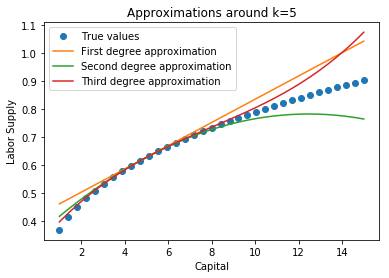

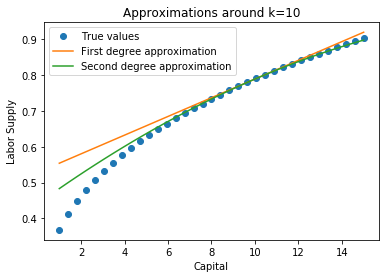

In [79]:
#Define some Functions
def labordemand(w, params):
    '''
    Defines the labor demand given w
    '''
    alpha, k, z, b, t, h = params
    nd = ( ( ( (1 - alpha) * z ) / w ) ** ( 1 / alpha ) ) * k
    return nd

def profit(w, params):
    '''
    Define profit function (labordemand(w) function is nested inside)
    '''
    alpha, k, z, b, t, h = params
    nd = labordemand(w, params)
    pi = z * k ** alpha * nd ** ( 1 - alpha ) - w * nd
    return pi

def laborsupply(w, params):
    '''
    Defines the labor supply given w 
    '''
    alpha, k, z, b, t, h = params
    pi = profit(w, params)
    ns =  h - (b / (w * (1 + b))) * (w * h + pi - t)
    return ns

def modelstatic(w, params):
    '''
    Defines n_d - n_s, which should be zero when markets clear
    Left p as a global since namedtuples don't seem to work with fsolve
    '''
    alpha, k, z, b, t, h = params
    error = laborsupply(w, params) - labordemand(w, params)
    return error

def getneq(k, params):
    k_new = k
    params = [alpha, k_new, z, b, t, h]
    n_eq = opt.fsolve(modelstatic, .1, args = params)
    # Reset Params
    params = [alpha, 5, z, b, t, h]
    return n_eq

#solve for equilibrium wage by setting modelstatic = 0
n_eq = getneq(5, params)
print("Equilibrium wage is: ", n_eq)

#Define function to get "actual" equilibrium wages over a grid.
def getpoints(N):
    #N is a resolution parameter (number of points in grid)
    kgrid = np.linspace(1, 15, N)
    ngrid = np.zeros(N)
    for i in range(N):
        k = kgrid[i]
        params = [alpha, k, z, b, t, h]
        ngrid[i] = opt.fsolve(modelstatic, .1, args=params)
    #reset k
    k = 5
    params = [alpha, k, z, b, t, h]
    return ngrid

'''
Find first and second derivative of equilibrium wage function at
a given point
'''

def getderivs(func, x_0, h, args = ()):
    '''
    Gets first and second derivatives of function func at a given point
    x_0 for perturbation h. Arguments of function pass through args
    '''
    # First derivative (use centered difference approximation cause why not)
    funcp = (func(x_0 + h, args) - func(x_0 - h, args)) / (2*h)
    # Second: Usual 2nd order difference quotient
    funcpp = (func(x_0 + h, args) - 2 * func(x_0, args) + func(x_0 - h, args)) / (h**2)
    funcppp = (func(x_0 + 2*h, args) - 2 * func(x_0 + h, args) + 2 * func(x_0 - h, args) - func(x_0 - 2*h, args))/(2*(h**3))

    return funcp, funcpp, funcppp

firstderiv, secondderiv, thirdderiv = getderivs(getneq, 5, 10e-6, args=params)

def getpoints(K, N):
    #N is a resolution parameter (number of points in grid)
    kgrid = np.linspace(1, 15, N)
    ntruegrid = np.zeros(N)
    ndeg1grid = np.zeros(N)
    ndeg2grid = np.zeros(N)
    ndeg3grid = np.zeros(N)
    for i in range(N):
        k = kgrid[i]
        params = [alpha, k, z, b, t, h]
        ntruegrid[i] = opt.fsolve(modelstatic, .1, args=params)
        #Taylor approximations at  5
        x_0 = K
        fx_0 = getneq(K, params)
        x = kgrid[i]
        fx = getneq(kgrid[i], params)
        firstderiv, secondderiv, thirdderiv = getderivs(getneq, x_0, 10e-2, args=params)
        ndeg1grid[i] = fx_0 + firstderiv * (x - x_0)
        ndeg2grid[i] = fx_0 + firstderiv * (x - x_0) + (secondderiv / 2) * (x - x_0) ** 2
        ndeg3grid[i] = ndeg2grid[i] + 1/6 * thirdderiv * (x - x_0) ** 3
    #reset k
    k = 5
    params = [alpha, k, z, b, t, h]
    return ntruegrid, ndeg1grid, ndeg2grid, ndeg3grid, kgrid

ntruegrid, ndeg1grid, ndeg2grid, ndeg3grid, kgrid = getpoints(5, 35)

plt.plot(kgrid, ntruegrid,  'o', label= "True values")
plt.plot(kgrid, ndeg1grid, label = "First degree approximation")
plt.plot(kgrid, ndeg2grid, label = "Second degree approximation")
plt.legend()
plt.title("Approximations around k=5")
plt.xlabel("Capital")
plt.ylabel("Labor Supply")
plt.show()

ntruegrid, ndeg1grid, ndeg2grid, ndeg3grid, kgrid = getpoints(10, 35)

plt.plot(kgrid, ntruegrid,  'o', label= "True values")
plt.plot(kgrid, ndeg1grid, label = "First degree approximation")
plt.plot(kgrid, ndeg2grid, label = "Second degree approximation")
plt.legend()
plt.title("Approximations around k=10")
plt.xlabel("Capital")
plt.ylabel("Labor Supply")
plt.show()

### Exercise 3

My code from Ex 2 wasn't general... sad.

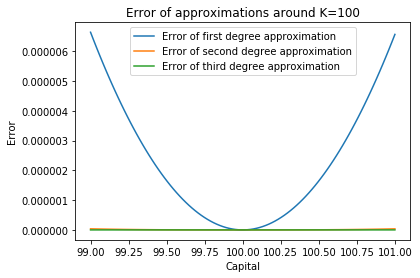

In [97]:
#Define function
def Ferr(y, x):
    #out = (x**0.35 + 0.9*x - y)**(-2.5) - 0.95*(y**0.35 + 0.9*y)**(-2.5)
    out = (x**0.35 + 0.9*x - y)**(-2.5) - 0.95*(y**0.35 + 0.9*y)**(-2.5)
    return out

#Root finder
def G(x, args):
    out = opt.fsolve(Ferr, 47, args=x, xtol=1e-9)
    return out

#Point getter
def geterrorpoints(x_0, N):
    args = ()
    #N is a resolution parameter (number of points in grid)
    xgrid = np.linspace(99, 101, N)
    ntruegrid = np.zeros(N)
    ndeg1grid = np.zeros(N)
    ndeg2grid = np.zeros(N)
    ndeg3grid = np.zeros(N)
    for i in range(N):
        ntruegrid[i] = G(xgrid[i], args)
        #Taylor approximations at  5
        fx_0 = G(x_0, args)
        x = xgrid[i]
        fx = G(xgrid[i], args)
        firstderiv, secondderiv, thirdderiv = getderivs(G, x_0, 10e-2)
        ndeg1grid[i] = fx_0 + firstderiv * (x - x_0)
        ndeg2grid[i] = fx_0 + firstderiv * (x - x_0) + (secondderiv / 2) * (x - x_0) ** 2
        ndeg3grid[i] = ndeg2grid[i] + 1/6 * thirdderiv * (x - x_0) ** 3
    ndeg1error = np.abs(ntruegrid - ndeg1grid)
    ndeg2error = np.abs(ntruegrid - ndeg2grid)
    ndeg3error = np.abs(ntruegrid - ndeg3grid)
    #return ntruegrid, ndeg1grid, ndeg2grid, ndeg3grid, xgrid
    return ndeg1error, ndeg2error, ndeg3error
getderivs(G, 100, 10e-2)

#ntruegrid, ndeg1grid, ndeg2grid, ndeg3grid, xgrid = getpoints(100, 100)
ndeg1error, ndeg2error, ndeg3error = geterrorpoints(100, 100)

plt.plot(xgrid, ndeg1error, label = "Error of first degree approximation")
plt.plot(xgrid, ndeg2error, label = "Error of second degree approximation")
plt.plot(xgrid, ndeg3error, label = "Error of third degree approximation")
plt.legend()
plt.title("Error of approximations around K=100")
plt.xlabel("Capital")
plt.ylabel("Error")
plt.show()

#Print Errors

### Exercise 5

I was still unable to get dolo to work, which made the rest of these problems impossible.

In [23]:
import dolo

ImportError: cannot import name 'sanitize'

In [22]:
fname = "ex5.yaml"
dolo.pcat(fname)
mod = dolo.yaml_import(fname)
mod_ss = dolo.algos.steady_state.find_steady_state(mod)
mod_ss

NameError: name 'dolo' is not defined

Model:
------
name: "BrockMirman"
type: "dtcscc"
file: "ex5.yaml

Equations:
----------

transition
 1  : -0.6500 : k = i(-1)
 2  : 0.0000 : z = rho*z(-1) + e_z

arbitrage
 1  : 0.5865 : 1 - beta*(c*r(1)/c(1)) | 0.0<= i <= inf